# Adding PSF convolution to all sources in `castor_etc`

Isaac Cheng - August 2023

This notebook is to accompany
[pull request#11](https://github.com/CASTOR-telescope/ETC/pull/11), which adds PSF
convolution to ALL sources. Moreover, the PSFs are the actual CASTOR PSFs, so we are no
longer assuming a simple Gaussian PSF. This update actually also simplifies calculations
in the backend, since we are using the same method (i.e., supersampling apertures) for all
sources.

This update also makes the photometry ETC truly 100% pixel-based. At first, our point
source calculations were not truly pixel based (i.e., you could change the source weights
and nothing would happen, as noted in the info message). With the previous PR
([#10](https://github.com/CASTOR-telescope/ETC/pull/10)), *none* of the sources were truly
pixel based (I know... -_-). But now, *all* sources are completely pixel-based! If
the user changes, e.g., some of the pixels in the point source array, it *will* affect
calculations!

Note that we are still using the fraction of flux contained within the aperture to do our
photometry calculations, except now our source weights give the fraction of flux contained
within each pixel directly. An enclosed flux fraction of 100% corresponds to the magnitude
of the source that the user set. So if I normalize a spectrum to, say, an AB magnitude of
25, then this AB magnitude will be the AB magnitude of the source if 100% of its flux was
contained within the aperture. If I choose an aperture that only contains 50% of the flux,
however, the effective AB magnitude will be dimmer.

As a final note, all PSF convolutions are done at 20x the resolution of the telescope's
detectors (following the resolution of the default PSF files, also see
[make_oversampled_psfs.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/master/make_oversampled_psfs.ipynb)).
Only after convolution do we bin the arrays down to the proper resolution.

This notebook is based on the
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb) notebook.

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import ExtendedSource, GalaxySource, PointSource
from castor_etc.telescope import Telescope

## Optimal aperture examples

We assume the PSFs provided by the user are sufficiently large to enclose roughly 100% of
the flux from the source, and we compare the flux contained within the aperture to the sum
of the PSF values.

To generate our source weights, we convolve a single bright pixel (i.e., 1 pixel at the
supersampled resolution) with the (supersampled) PSF, then we apply an aperture mask and
bin the arrays down to the proper resolution. I've checked that this gives the same result
as manually slicing the PSF image to the extent of the aperture (the former method is just
easier and gives more flexibility).

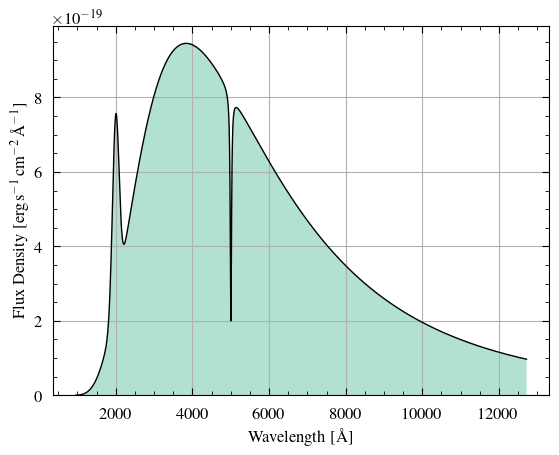

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



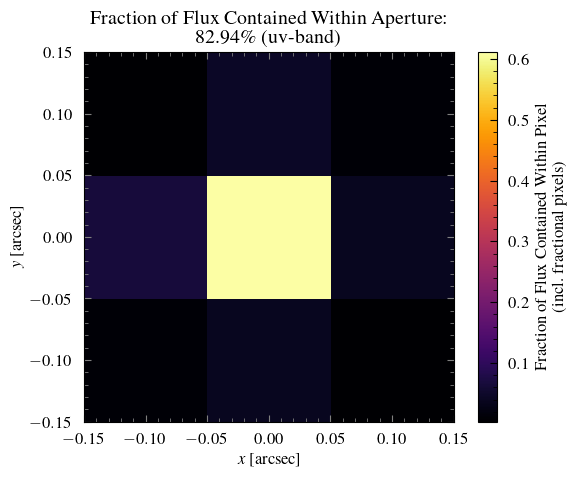

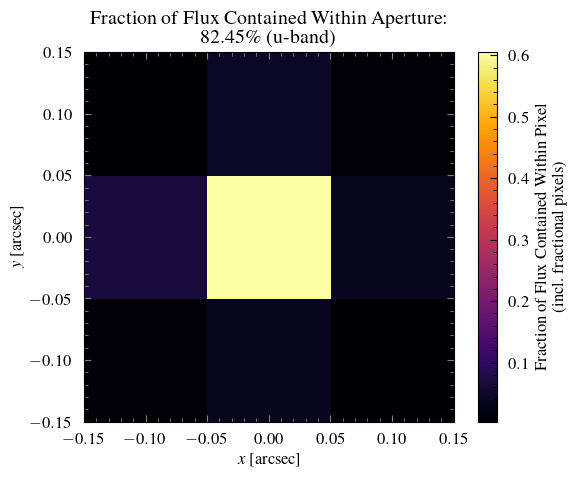

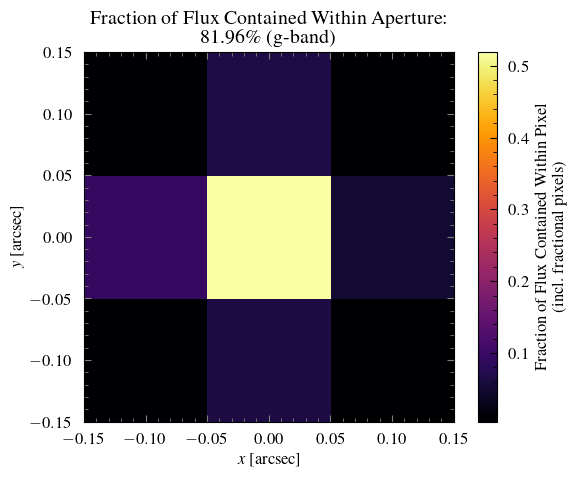

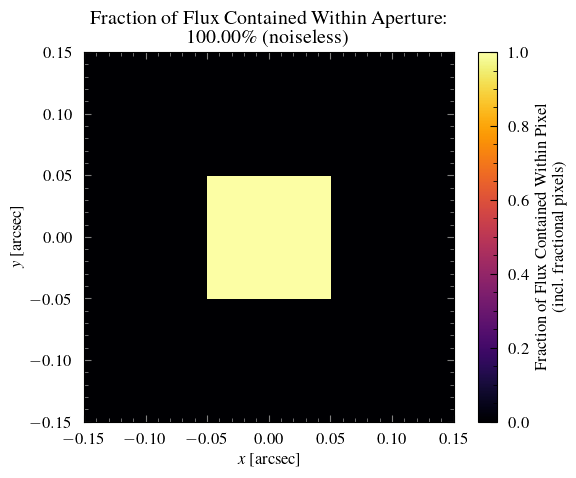

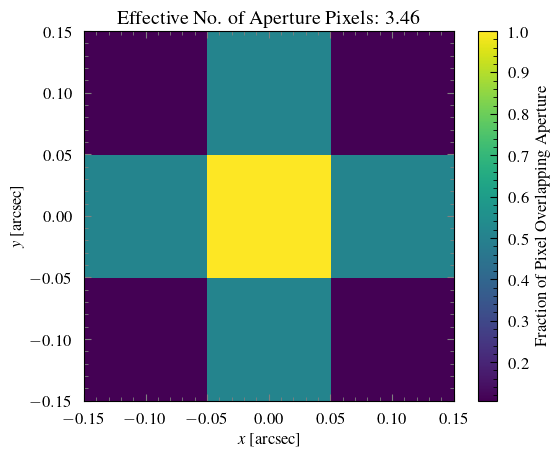

INFO: Fraction of flux within aperture in uv-band = 0.8293798933436634
INFO: Fraction of flux within aperture in u-band = 0.8244727770475812
INFO: Fraction of flux within aperture in g-band = 0.8196217365656141

Time (s) required to reach SNR=10 in uv-band 1129.0219694886084
SNR achieved in t=1129.0219694886084 seconds in uv-band 10.000000000000002

Time (s) required to reach SNR=10 in u-band 232.30920707232838
SNR achieved in t=232.30920707232838 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 123.56362424106277
SNR achieved in t=123.56362424106277 seconds in g-band 9.999999999999998



In [2]:
# Same as the 1st example in
# [getting_started_photometry.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/a5357452875033a6e4e28f001d55210871c02cfa/getting_started_photometry.ipynb)

MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_optimal_aperture(factor=1.4)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Now what if we change the source weights? For example, let's double the flux through the
brightest pixel.

(Note that this leads to an encircled energy > 100%, which is not physical. This is just
to demonstrate how changing the source weights *will* affect calculations, even for point
sources.)

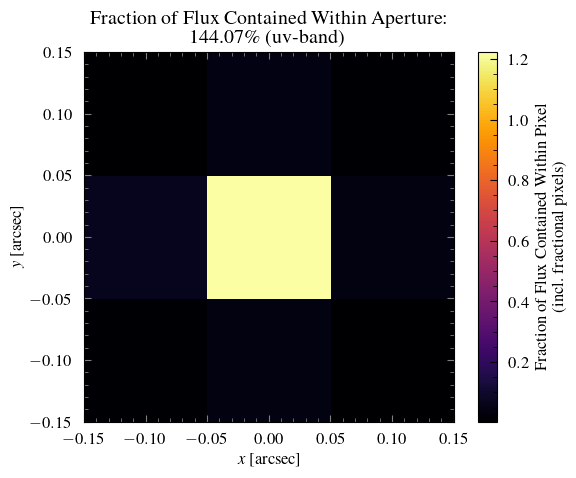

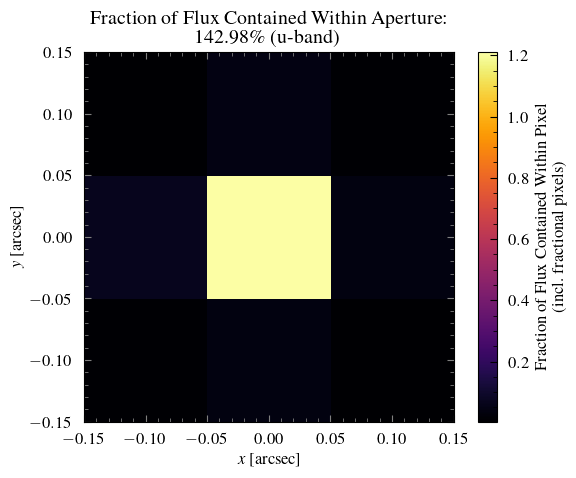

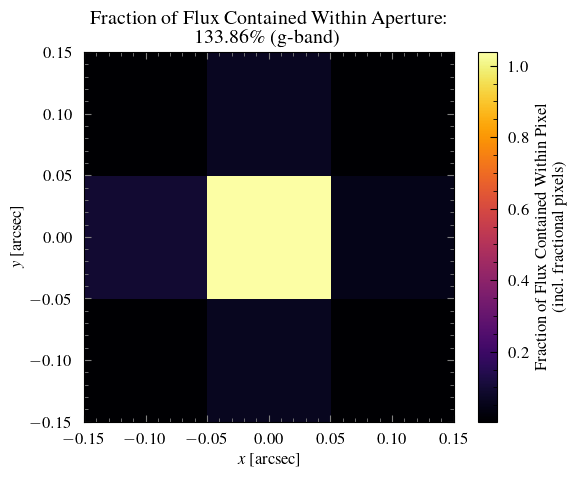

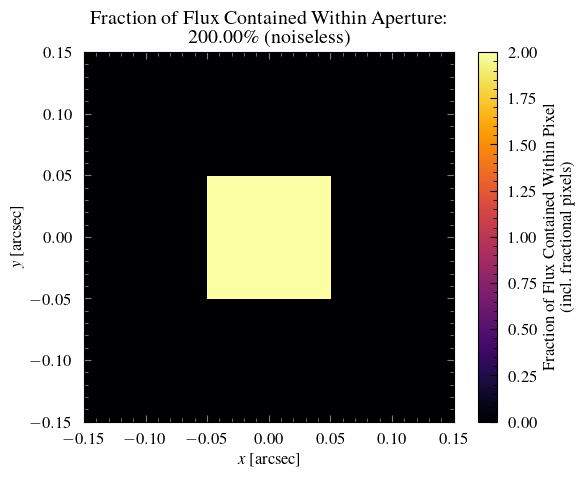

INFO: Fraction of flux within aperture in uv-band = 1.4406596550093915
INFO: Fraction of flux within aperture in u-band = 1.4298202474830768
INFO: Fraction of flux within aperture in g-band = 1.3386424998197273

Time (s) required to reach SNR=10 in uv-band 600.9771872830788
SNR achieved in t=600.9771872830788 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 130.2167573587922
SNR achieved in t=130.2167573587922 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 70.91927541833938
SNR achieved in t=70.91927541833938 seconds in g-band 10.0



In [3]:
for band in MyPhot.source_weights:
    # Double flux through brightest pixel
    MyPhot.source_weights[band][
        abs(MyPhot.source_weights[band] - np.nanmax(MyPhot.source_weights[band])) < 1e-15
    ] *= 2
    MyPhot.show_source_weights(band)


TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Elliptical aperture examples

### Point source with elliptical aperture

We recover the same results as those from the optimal aperture when we set the same
parameters.

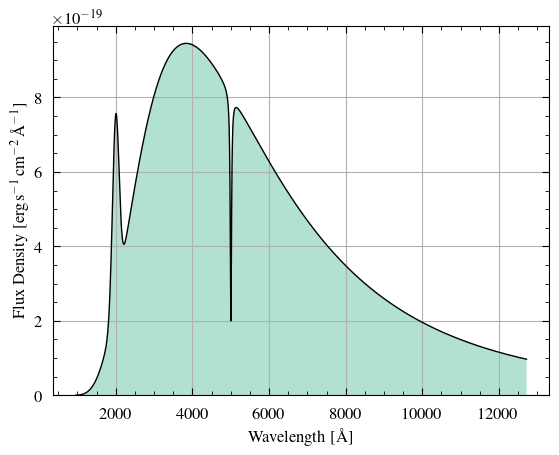

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



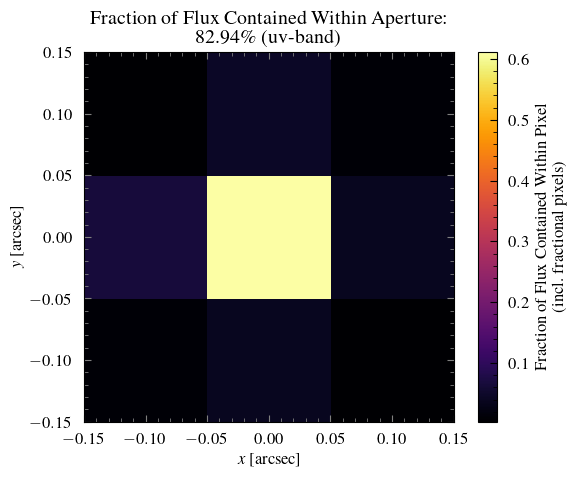

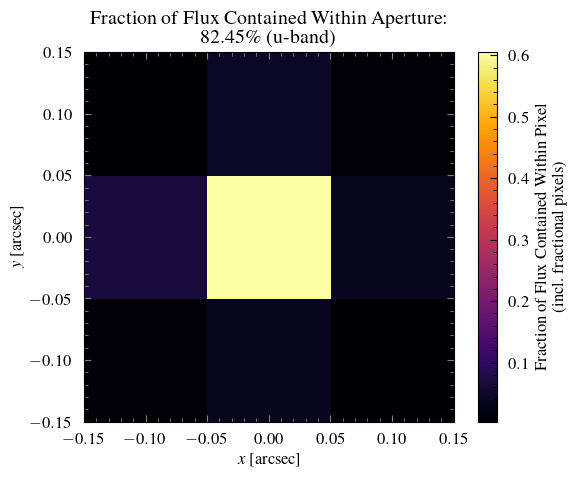

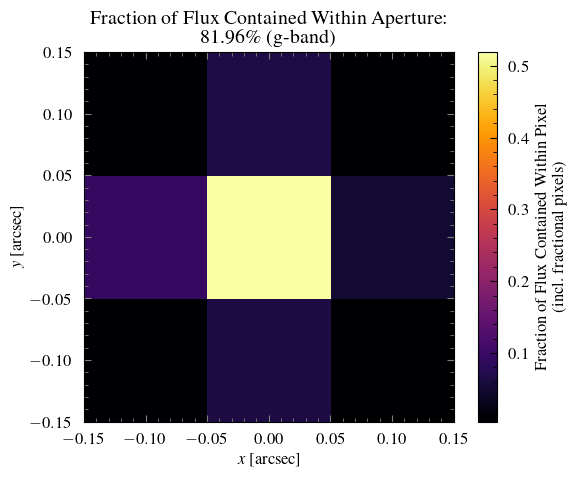

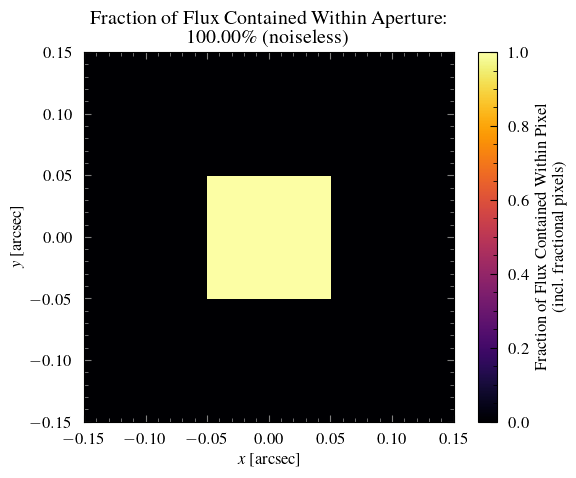

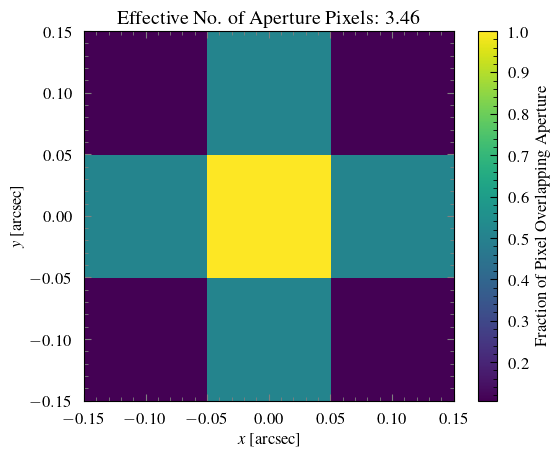

INFO: Fraction of flux within aperture in uv-band = 0.8293798933436634
INFO: Fraction of flux within aperture in u-band = 0.8244727770475812
INFO: Fraction of flux within aperture in g-band = 0.8196217365656141

Time (s) required to reach SNR=10 in uv-band 1129.0219694886084
SNR achieved in t=1129.0219694886084 seconds in uv-band 10.000000000000002

Time (s) required to reach SNR=10 in u-band 232.30920707232838
SNR achieved in t=232.30920707232838 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 123.56362424106277
SNR achieved in t=123.56362424106277 seconds in g-band 9.999999999999998



In [4]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(a=a, b=b, center=[0, 0] * u.arcsec)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

Now we use an off-centred elliptical aperture for a point source.

To emphasize, we convolve the (supersampled) PSF with the supersampled aperture, then we
bin the arrays down to the ones shown below. This means that we are *not* simply
convolving the 1 bright pixel shown in the final "noiseless" array. Rather, that final
bright pixel simply means that the single bright pixel generated in the supersampled
source arrays happened to land within the extent of that final pixel.

(Notice the extent of the axes have changed. The centre of the source will always be at
(0,0), and the centre of the aperture will be at the coordinate specified.)

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



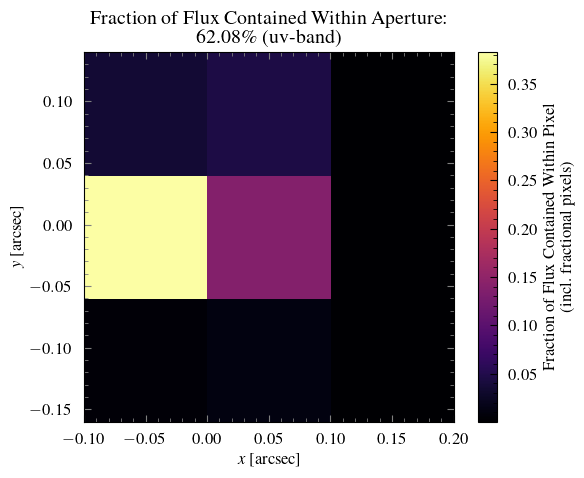

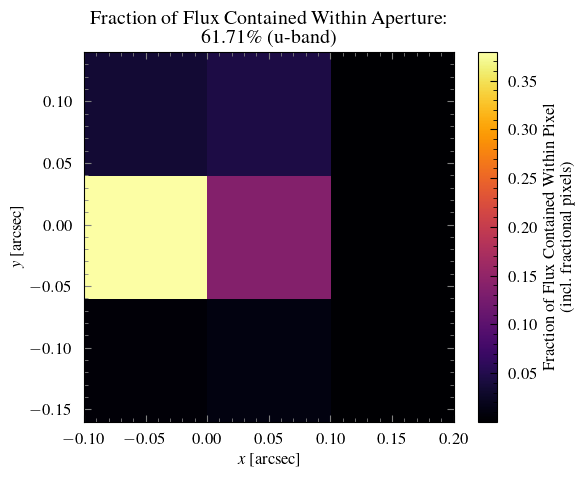

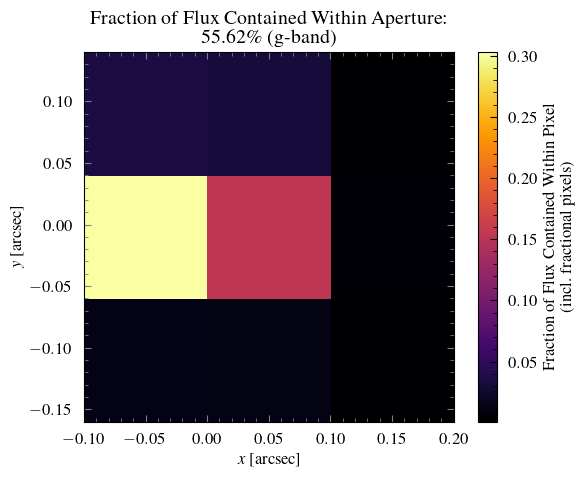

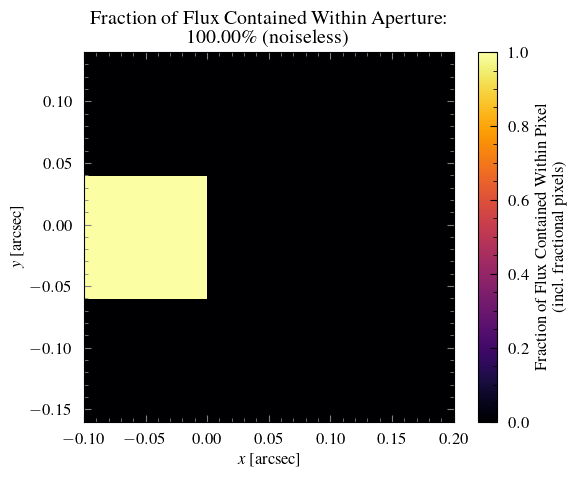

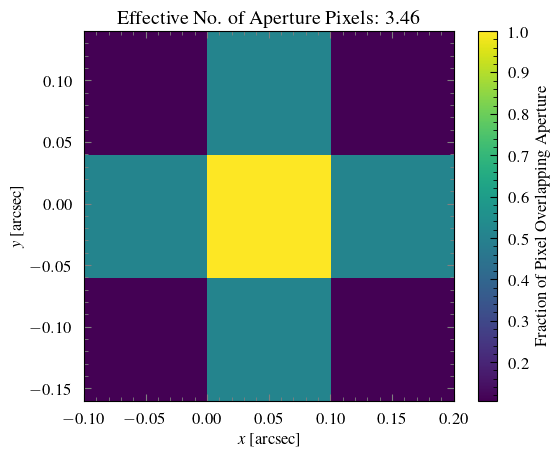

INFO: Fraction of flux within aperture in uv-band = 0.6207658887851039
INFO: Fraction of flux within aperture in u-band = 0.6171106398659659
INFO: Fraction of flux within aperture in g-band = 0.5562012449490924

Time (s) required to reach SNR=10 in uv-band 1599.463051260171
SNR achieved in t=1599.463051260171 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 317.2793789645929
SNR achieved in t=317.2793789645929 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 196.16261977939638
SNR achieved in t=196.16261977939638 seconds in g-band 10.0



In [5]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
a = b = 1.4 * (MyTelescope.fwhm / 2)
MyPhot.use_elliptical_aperture(a=a, b=b, center=[0.05, -0.01] * u.arcsec)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with elliptical aperture

Below, we see an aperture the size of the half-light radius enclosing half the light from
the (noiseless) galaxy, as expected.

Since a source's attributes are independent of aperture or telescope, we set the
*noiseless* image to act as the reference flux for the passbands (that *have* been
convolved with their respective PSF). Below, notice how the fraction of flux enclosed in
the same aperture varies depending on the PSF. Only in the noiseless case will an aperture
with dimensions equal to the galaxy's half-light radius enclose 50% of the light from the
source.

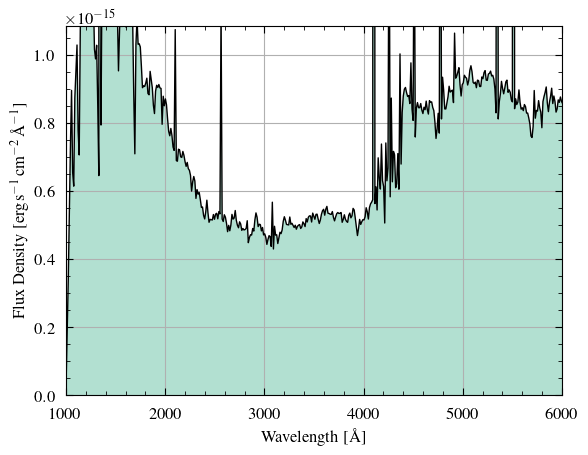

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



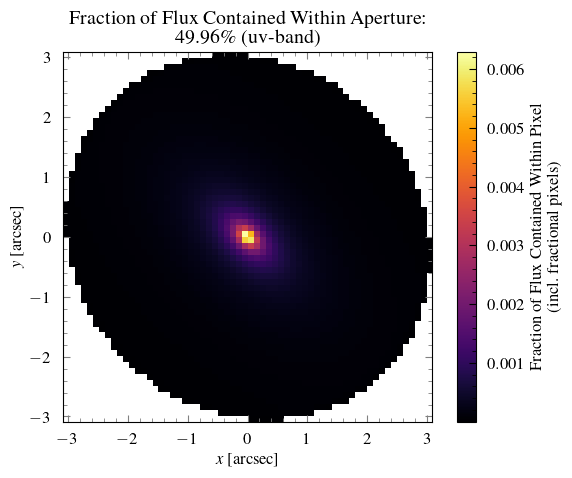

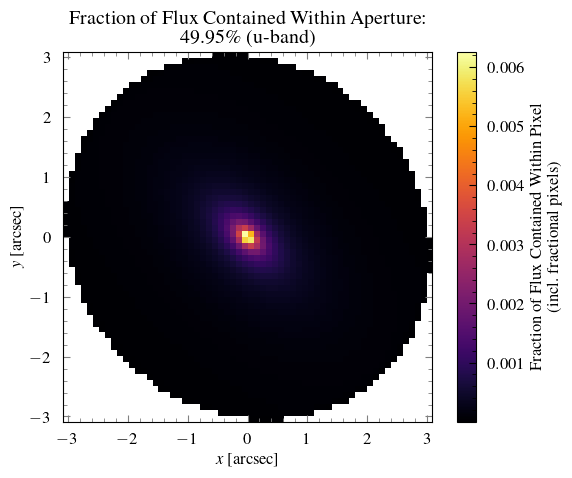

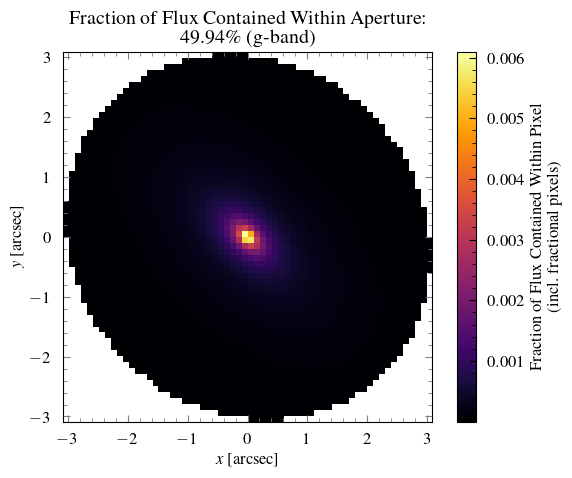

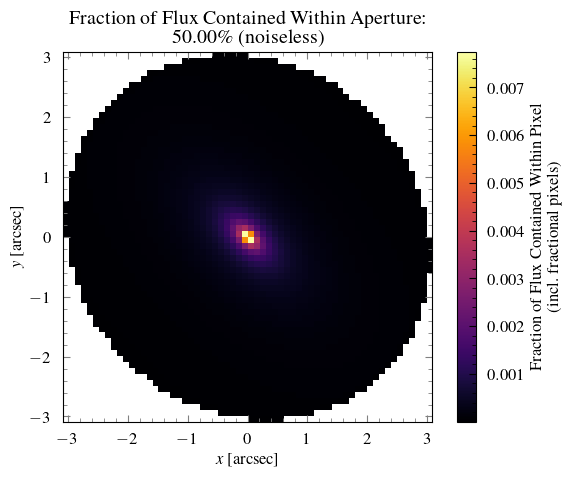

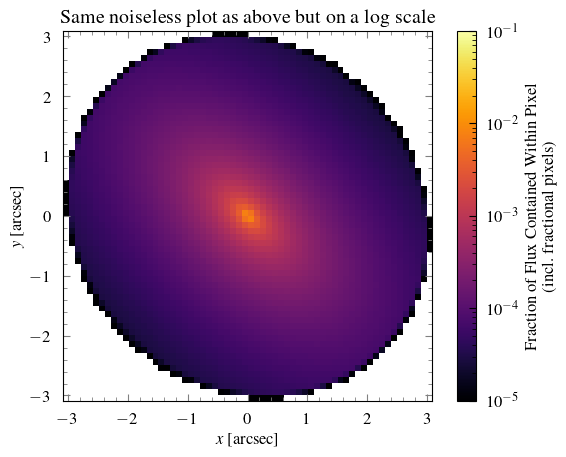

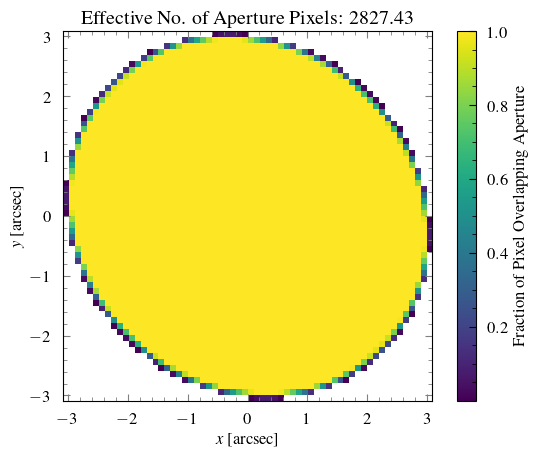

INFO: Fraction of flux within aperture in uv-band = 0.4995614374641739
INFO: Fraction of flux within aperture in u-band = 0.49954324612398404
INFO: Fraction of flux within aperture in g-band = 0.49939373552523947

SNR achieved in t=4321 seconds in uv-band 585.1830266695545
Time (s) required to reach SNR=585.1830266695545 in uv-band 4320.999999999998

SNR achieved in t=4321 seconds in u-band 792.6963422329106
Time (s) required to reach SNR=792.6963422329106 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1708.8687180761099
Time (s) required to reach SNR=1708.8687180761099 in g-band 4321.000000000001



In [6]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=MySource.angle_a,
    b=MySource.angle_b,
    center=[0, 0] * u.arcsec,
    rotation=np.rad2deg(MySource.rotation),
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
fig, ax, img, cbar = MyPhot.show_source_weights(
    "noiseless", norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False
)
ax.set_title("Same noiseless plot as above but on a log scale")
plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

Now we move the aperture off centre and increase its eccentricity.

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



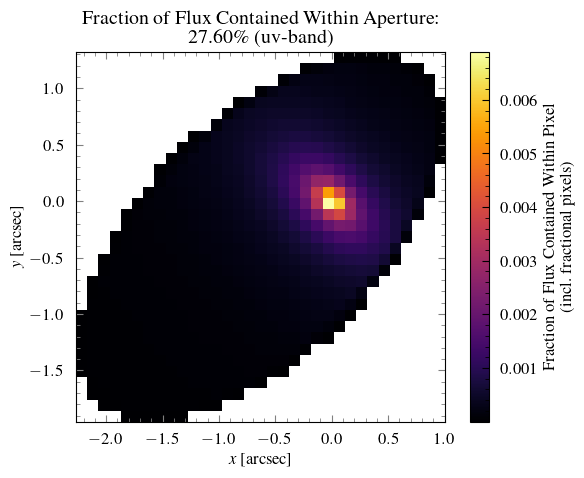

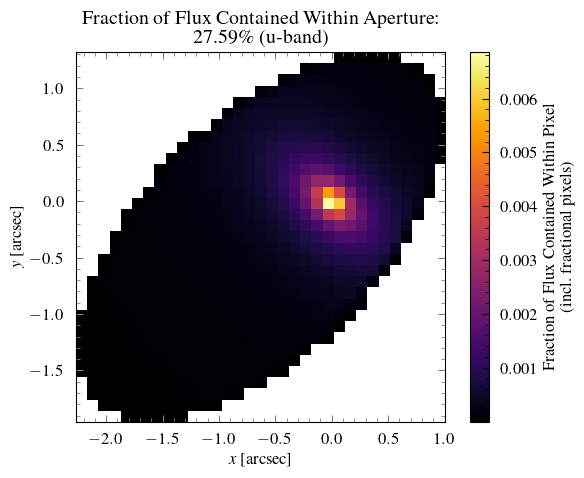

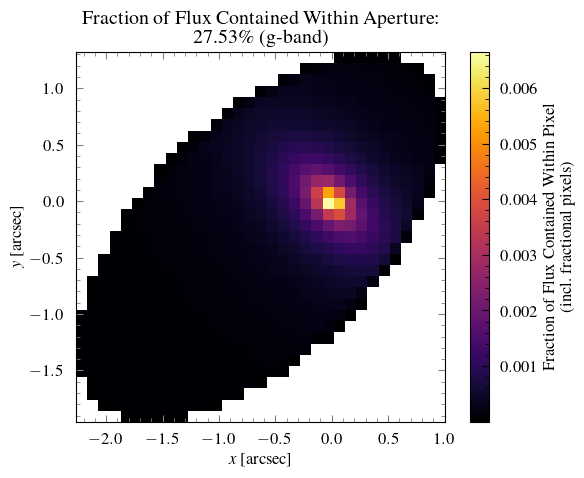

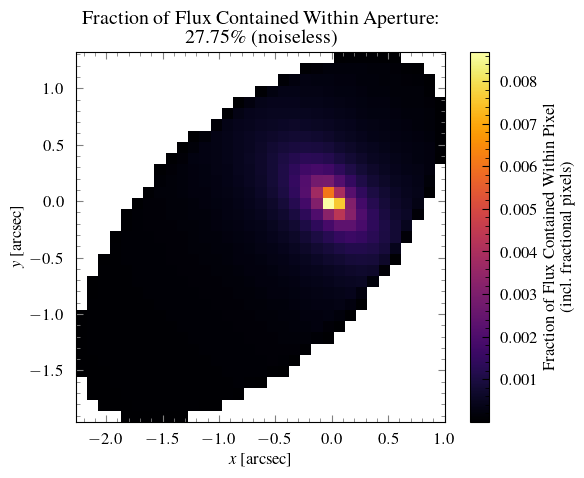

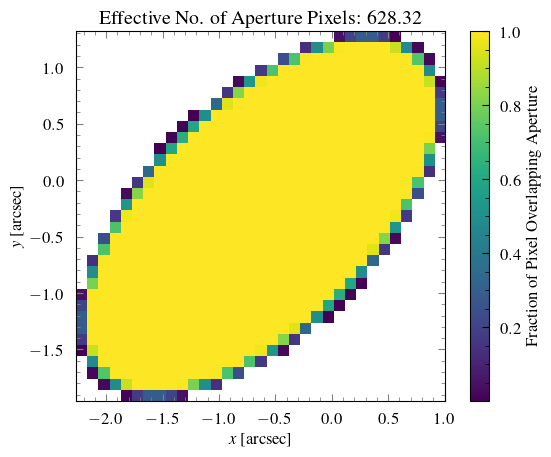

INFO: Fraction of flux within aperture in uv-band = 0.2759840971032302
INFO: Fraction of flux within aperture in u-band = 0.27589513822513906
INFO: Fraction of flux within aperture in g-band = 0.27528816506112114

SNR achieved in t=4321 seconds in uv-band 452.3249200517186
Time (s) required to reach SNR=452.3249200517186 in uv-band 4321.000000000001

SNR achieved in t=4321 seconds in u-band 624.9318084128225
Time (s) required to reach SNR=624.9318084128225 in u-band 4321.0

SNR achieved in t=4321 seconds in g-band 1353.792102233078
Time (s) required to reach SNR=1353.792102233078 in g-band 4321.000000000001



In [7]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    2 * u.arcsec,
    1 * u.arcsec,
    center=np.array([-0.2, -0.1]) * MySource.angle_a,
    rotation=45,
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with elliptical aperture

We see that an aperture with the same extent as an extended source encloses 100% of its
flux, only in the noiseless case. This is by our definition.

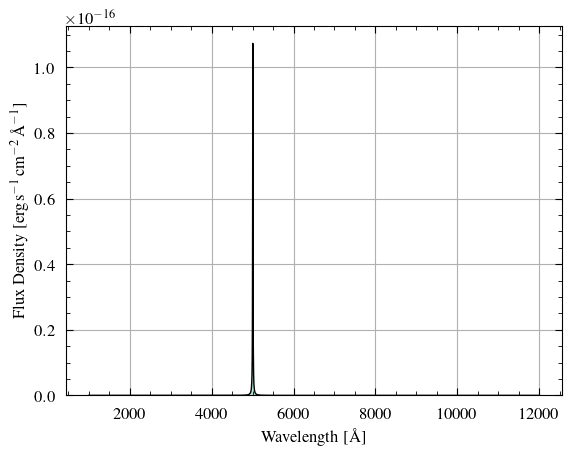

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


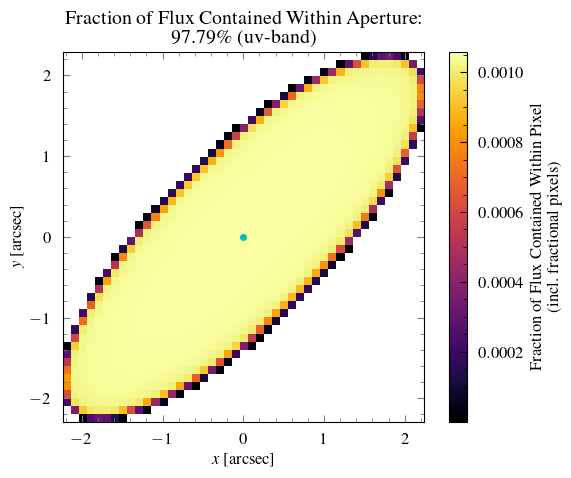

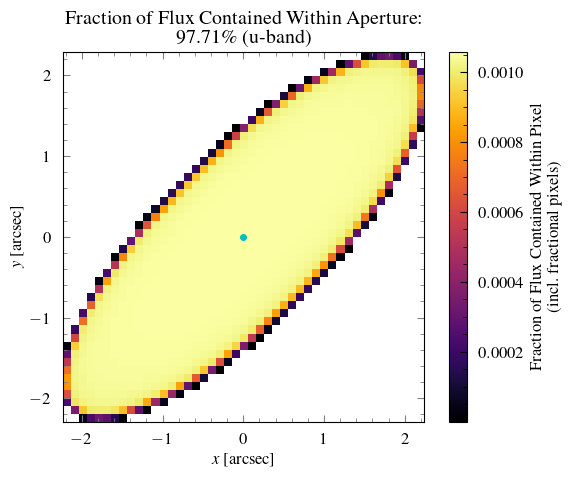

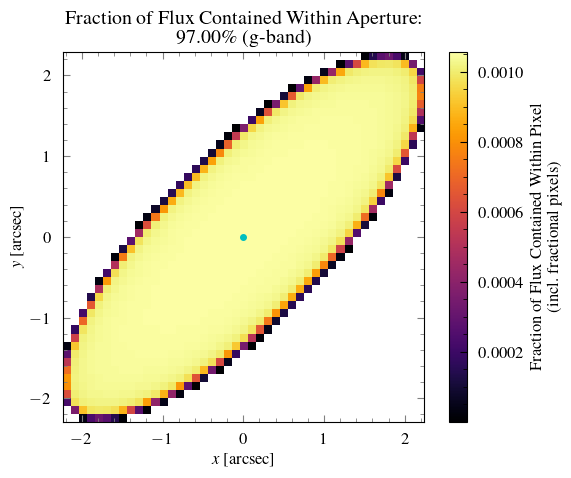

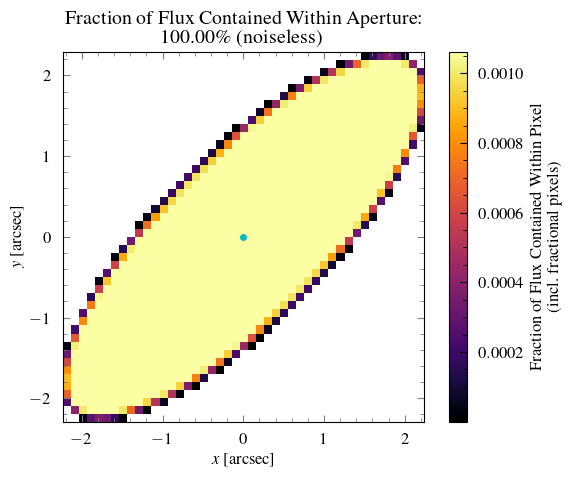

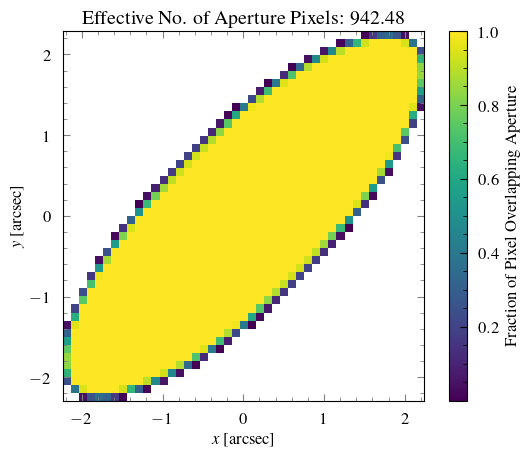

INFO: Fraction of flux within aperture in uv-band = 0.9778639875146131
INFO: Fraction of flux within aperture in u-band = 0.9770820431898546
INFO: Fraction of flux within aperture in g-band = 0.9700091803399654

Time (s) required to reach SNR=10 in uv-band 468346770.93434465
SNR achieved in t=468346770.93434465 seconds in uv-band 10.000000000000004

Time (s) required to reach SNR=10 in u-band 1101618151858603.1
SNR achieved in t=1101618151858603.1 seconds in u-band 10.000000000000002

Time (s) required to reach SNR=10 in g-band 2089.449383942002
SNR achieved in t=2089.449383942002 seconds in g-band 10.000000000000002



In [8]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=3 * u.arcsec, b=1 * u.arcsec, rotation=45)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

If we increase the size of the aperture but keep the entire source enclosed, the fraction
of flux within the noiseless aperture is still 100%, but the time required to reach our
target SNR increases because there are many more background pixels.

Also, the reason why the SNR and integration time calculation below is different from the
corresponding cell in
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb)
is because I fixed a small bug where I was doubly-applying the aperture mask to certain
arrays (like the dark current and sky background noise arrays).


Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


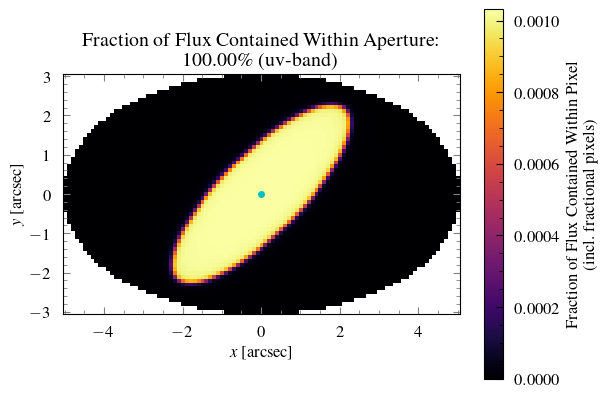

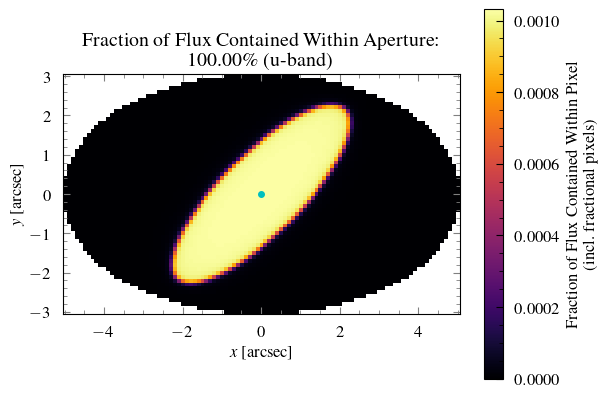

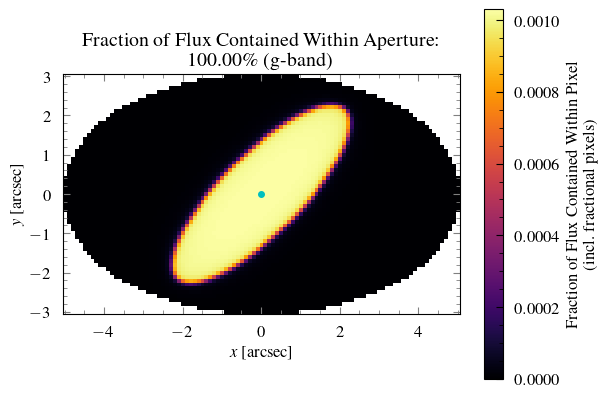

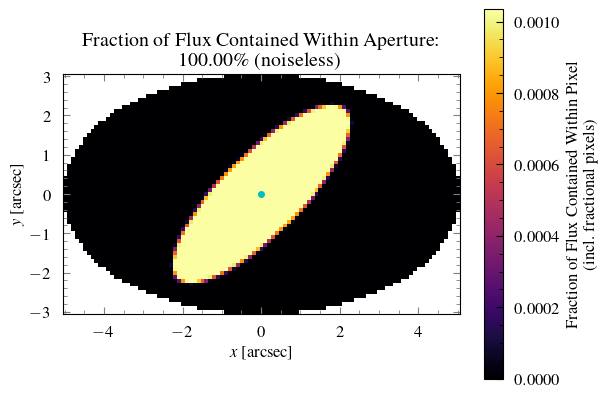

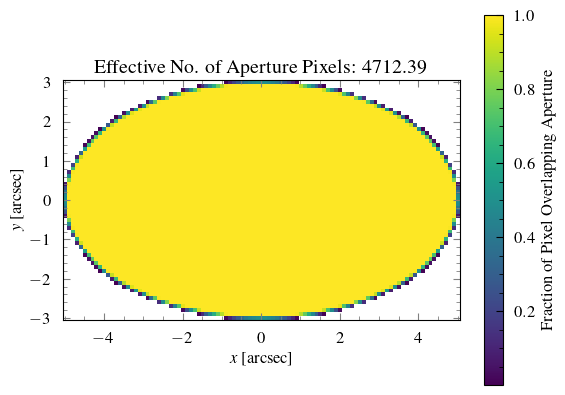

INFO: Fraction of flux within aperture in uv-band = 1.0
INFO: Fraction of flux within aperture in u-band = 1.0
INFO: Fraction of flux within aperture in g-band = 1.0

Time (s) required to reach SNR=10 in uv-band 2238964946.724113
SNR achieved in t=2238964946.724113 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 5258515184890872.0
SNR achieved in t=5258515184890872.0 seconds in u-band 10.0

Time (s) required to reach SNR=10 in g-band 9478.855789029545
SNR achieved in t=9478.855789029545 seconds in g-band 10.0



In [9]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(a=5 * u.arcsec, b=3 * u.arcsec, rotation=0)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

We can also create an off-centre aperture that is oriented perpendicular to the source
because we are bad astronomers

BTW, the small $<0.3$% difference in the enclosed flux fraction below compared to the same
cell in
[photometry_update.ipynb](https://github.com/CASTOR-telescope/ETC_notebooks/blob/4f6bbb10c62e30a312ebe0e129990b1c778d8c46/photometry_update.ipynb)
notebook is due to the slightly different way that I am defining the boundary of the
aperture. This doesn't change the total number of aperture pixels, but it does shift the
source within the aperture ever so slightly. The pointing should be more accurate now.

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1134: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


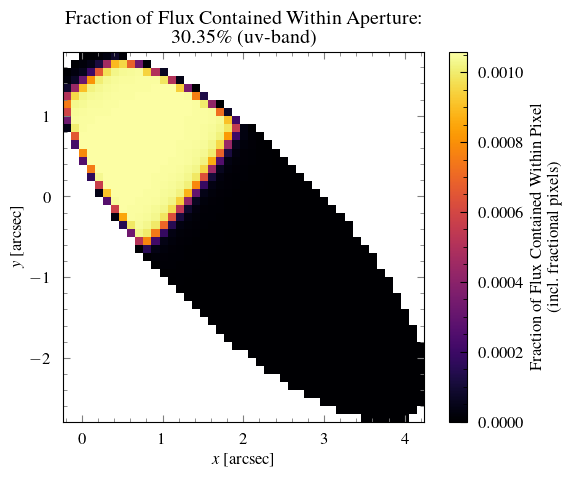

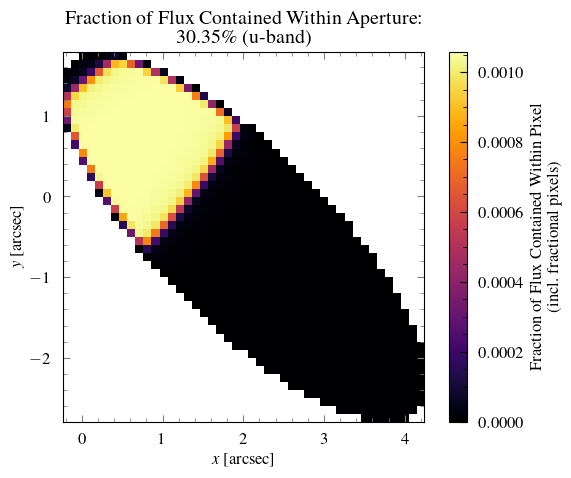

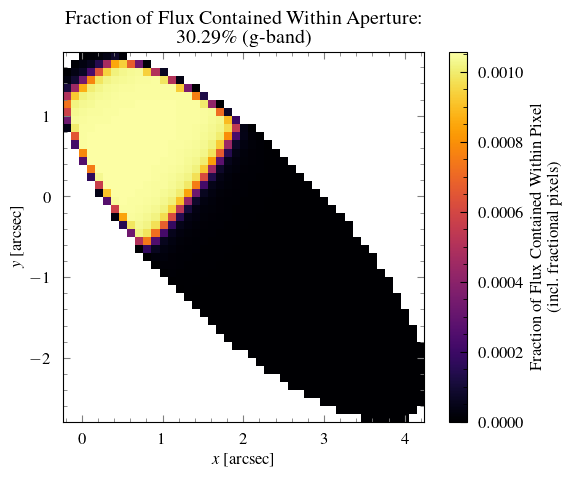

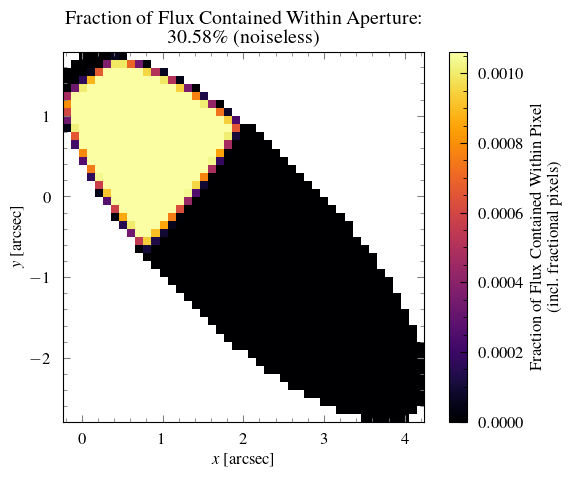

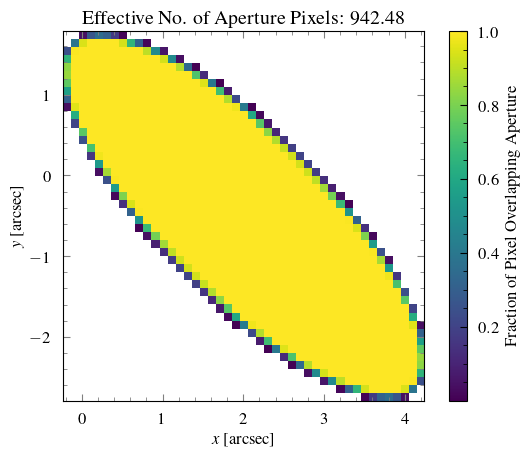

INFO: Fraction of flux within aperture in uv-band = 0.3035150203871612
INFO: Fraction of flux within aperture in u-band = 0.3034781610571955
INFO: Fraction of flux within aperture in g-band = 0.3029285079044771

Time (s) required to reach SNR=10 in uv-band 4860972023.668952
SNR achieved in t=4860972023.668952 seconds in uv-band 10.0

Time (s) required to reach SNR=10 in u-band 1.1419267407258842e+16
SNR achieved in t=1.1419267407258842e+16 seconds in u-band 10.000000000000004

Time (s) required to reach SNR=10 in g-band 20658.188618776938
SNR achieved in t=20658.188618776938 seconds in g-band 9.999999999999998



In [10]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=3 * u.arcsec, b=1 * u.arcsec, rotation=135, center=[2, -0.5] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

## Rectangular aperture examples

### Point source with rectangular aperture

In this case, the default colormap makes it hard to see some of the subtle differences in
the source weights. We will change it to another colormap

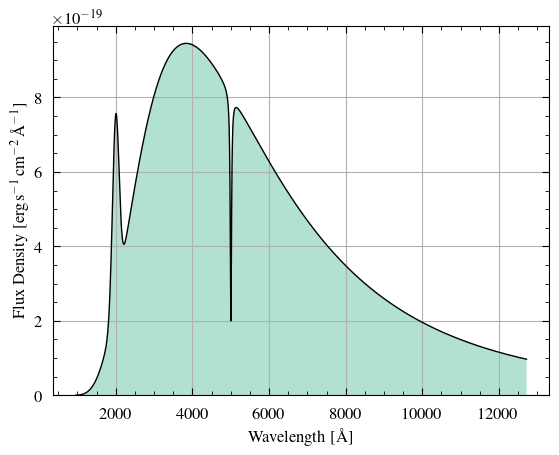

Bolometric AB magnitude: 24.999142761583535
Passband AB magnitudes: {'uv': 26.484461204831213, 'u': 25.009805288085623, 'g': 24.436944919160602}



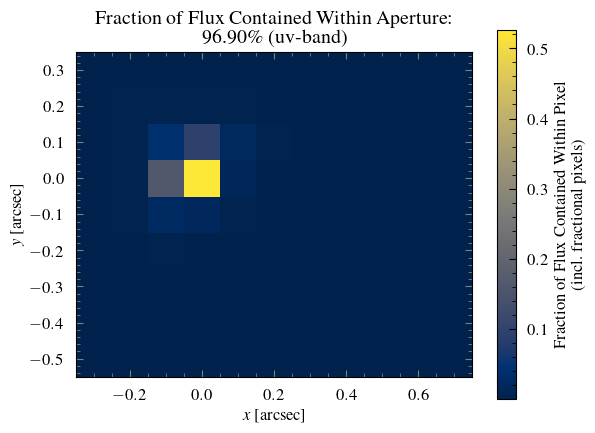

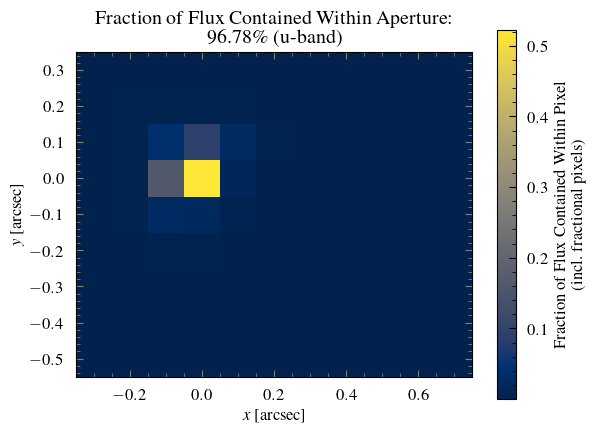

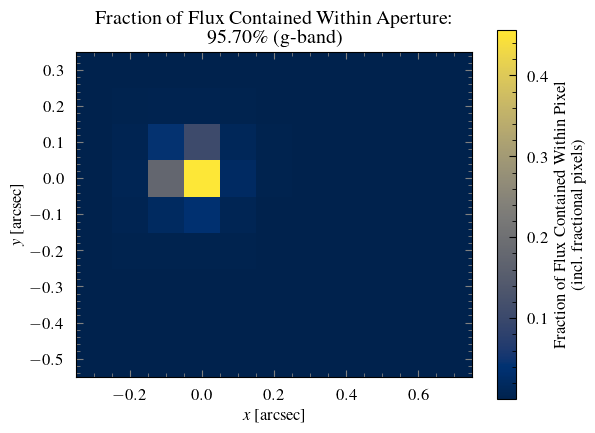

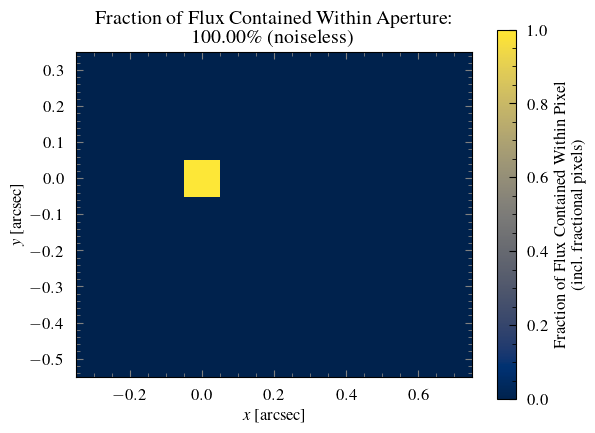

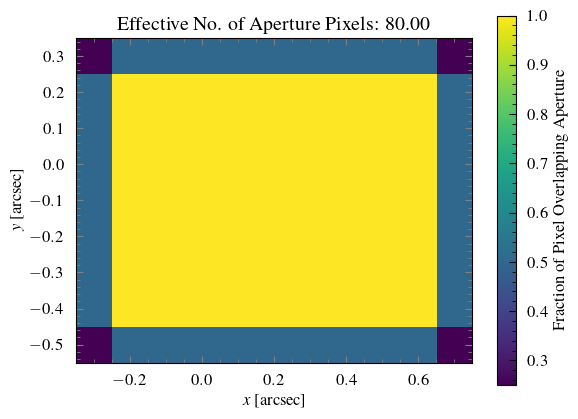

INFO: Fraction of flux within aperture in uv-band = 0.9690484552006169
INFO: Fraction of flux within aperture in u-band = 0.9678171468277126
INFO: Fraction of flux within aperture in g-band = 0.957023527990241

Time (s) required to reach SNR=10 in uv-band 4728.680581975338
SNR achieved in t=4728.680581975338 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 589.8839720162443
SNR achieved in t=589.8839720162443 seconds in u-band 9.999999999999996

Time (s) required to reach SNR=10 in g-band 487.18140387511335
SNR achieved in t=487.18140387511335 seconds in g-band 9.999999999999998



In [11]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(flux="high")

MySource = PointSource()
MySource.generate_bb(8000 * u.K, redshift=0.06)
MySource.norm_to_AB_mag(25)
MySource.add_emission_line(
    center=2000 * u.AA, fwhm=200 * u.AA, peak=5e-19, shape="gaussian", abs_peak=False
)
MySource.add_absorption_line(
    center=5005 * u.AA, fwhm=40 * u.AA, dip=2e-19, shape="lorentzian", abs_dip=True
)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=1 * u.arcsec, length=0.8 * u.arcsec, center=[0.2, -0.1] * u.arcsec
)

for band in MyPhot.source_weights:
    fig, ax, img, cbar = MyPhot.show_source_weights(band, plot=False)
    img.set_cmap("cividis")
    plt.show()
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()

### Galaxy source with rectangular aperture

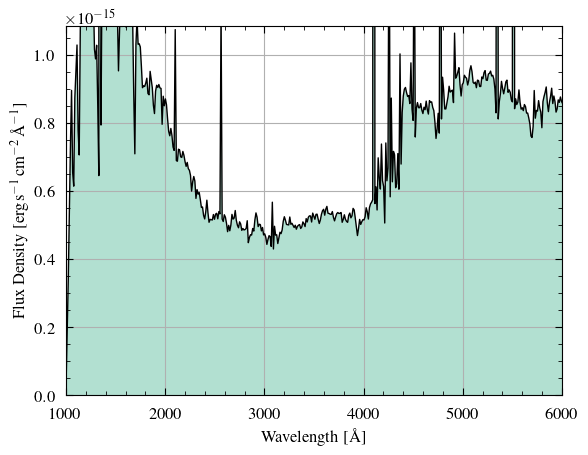

Bolometric AB magnitude: 16.458904724098822
Passband AB magnitudes: {'uv': 18.76106637720853, 'u': 18.136436380681552, 'g': 16.678916334742347}



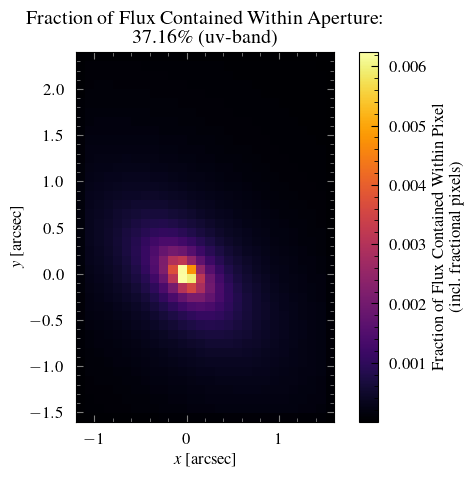

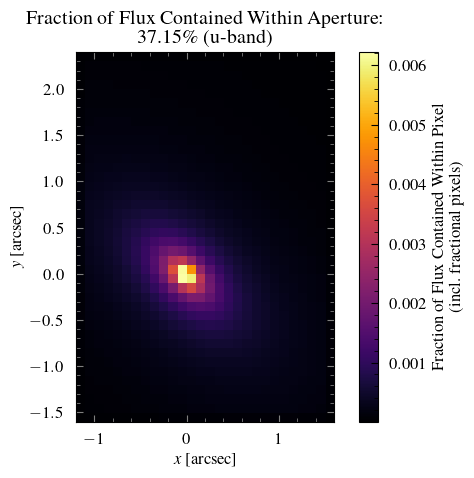

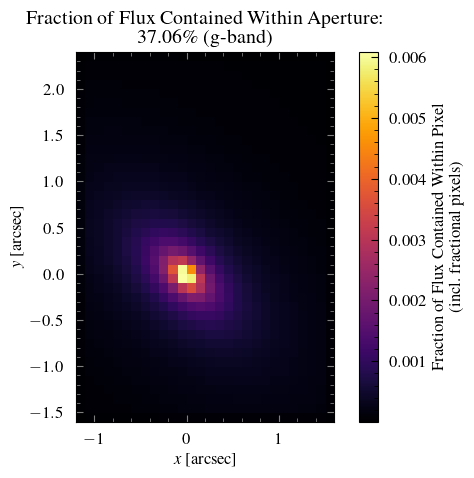

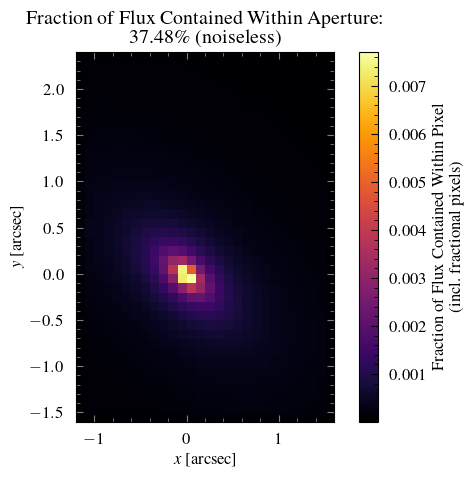

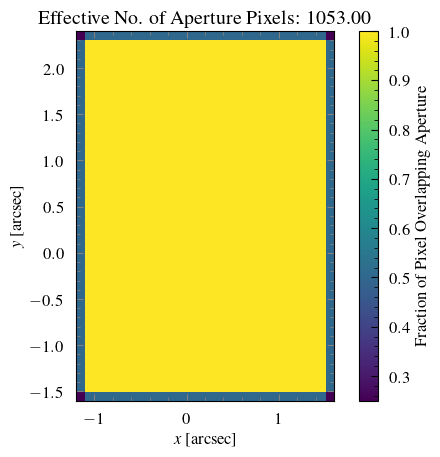

INFO: Fraction of flux within aperture in uv-band = 0.3716479939826478
INFO: Fraction of flux within aperture in u-band = 0.37154250339824046
INFO: Fraction of flux within aperture in g-band = 0.3705870439408812

SNR achieved in t=4321 seconds in uv-band 521.4160802924131
Time (s) required to reach SNR=521.4160802924131 in uv-band 4320.999999999999

SNR achieved in t=4321 seconds in u-band 717.8475025969956
Time (s) required to reach SNR=717.8475025969956 in u-band 4320.999999999999

SNR achieved in t=4321 seconds in g-band 1553.0435748908028
Time (s) required to reach SNR=1553.0435748908028 in g-band 4321.000000000001



In [12]:
MyTelescope = Telescope()

MyBackground = Background()
MyBackground.add_geocoronal_emission(
    flux=1e-15, wavelength=2345 * u.AA, linewidth=0.023 * u.AA
)

MySource = GalaxySource(r_eff=3 * u.arcsec, n=4, axial_ratio=0.9, rotation=135)

MySource.use_galaxy_spectrum(gal_type="spiral")
MySource.norm_luminosity_dist(luminosity=1.4e9, dist=58.3 * u.Mpc)
MySource.redshift_wavelengths(0.1)
fig, ax = MySource.show_spectrum(plot=False)
ax.set_xlim(1000, 6000)
ax.set_ylim(top=np.percentile(MySource.spectrum, 96))
plt.show()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()


MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=2.7 * u.arcsec, length=3.9 * u.arcsec, center=[0.2, 0.4] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band)
# fig, ax, cbar = MyPhot.show_source_weights(
#     "noiseless", norm=LogNorm(vmin=1e-5, vmax=0.1), plot=False
# )
# ax.set_title("Same noiseless plot as above but on a log scale")
# plt.show()
MyPhot.show_aper_weights()

INTEGRATION_TIME = 4321
REDDENING = 0.01

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    snr = MyPhot.calc_snr_or_t(t=INTEGRATION_TIME, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"SNR achieved in t={INTEGRATION_TIME} seconds in {band}-band", snr)
    time = MyPhot.calc_snr_or_t(snr=snr, reddening=REDDENING, quiet=quiet)[band]
    print(f"Time (s) required to reach SNR={snr} in {band}-band", time)
    print()

### Extended source with rectangular aperture

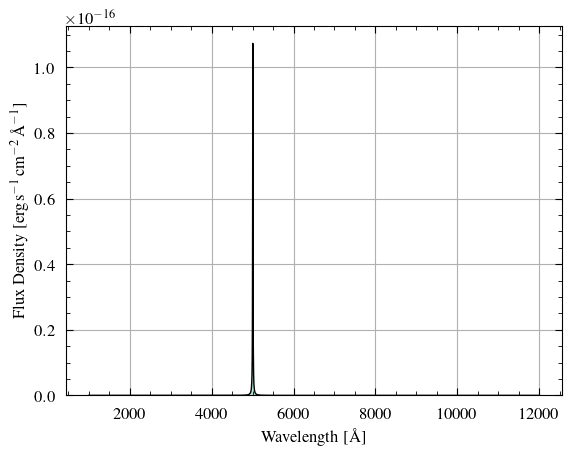

Bolometric AB magnitude: 26.2721435361674
Passband AB magnitudes: {'uv': 31.463107529100533, 'u': 39.00305848994173, 'g': 24.000000000000007}



/arc/home/IsaacCheng/CASTOR/ETC/castor_etc/photometry.py:1372: UserWarning: The ExtendedSource calculation assumes 100% of the flux is contained within the size defined in the ExtendedSource (i.e., by angle_a and angle_b).
  warnings.warn(


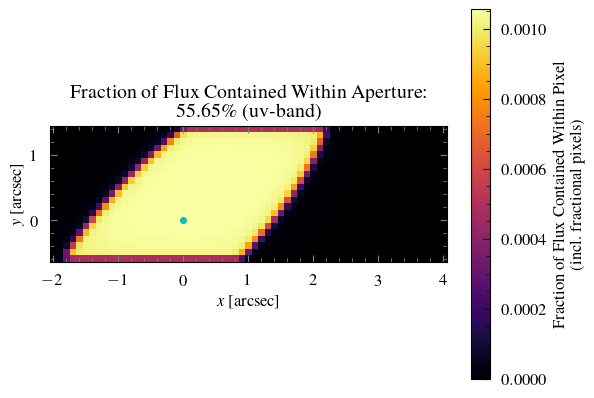

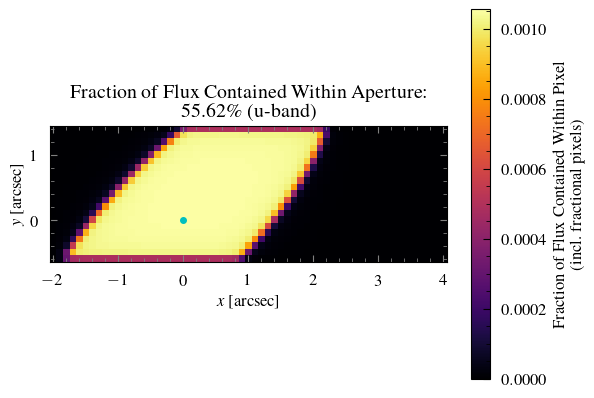

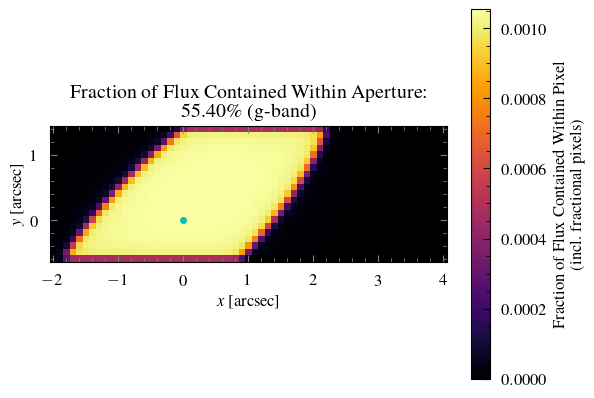

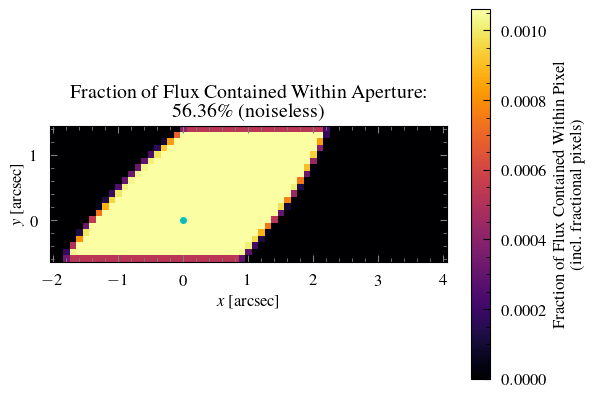

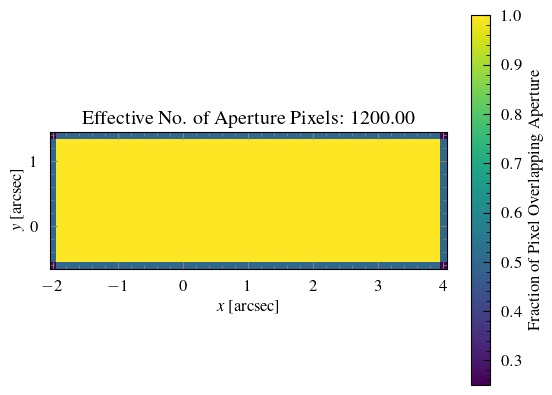

INFO: Fraction of flux within aperture in uv-band = 0.5565469813734494
INFO: Fraction of flux within aperture in u-band = 0.5562051159454546
INFO: Fraction of flux within aperture in g-band = 0.5539510474303073

Time (s) required to reach SNR=10 in uv-band 1840763769.40209
SNR achieved in t=1840763769.40209 seconds in uv-band 9.999999999999998

Time (s) required to reach SNR=10 in u-band 4328458860572442.5
SNR achieved in t=4328458860572442.5 seconds in u-band 10.000000000000002

Time (s) required to reach SNR=10 in g-band 7920.787986448474
SNR achieved in t=7920.787986448474 seconds in g-band 10.000000000000002



In [13]:
MyTelescope = Telescope(dark_current=0.01)

MyBackground = Background(mags_per_sq_arcsec={"uv": 26.08, "u": 23.74, "g": 22.60})
MySource = ExtendedSource(
    angle_a=3 * u.arcsec, angle_b=1 * u.arcsec, rotation=45, profile="uniform"
)

MySource.generate_emission_line(
    center=5007 * u.AA, fwhm=10 * u.AA, peak=7e-21, shape="lorentzian"
)
MySource.norm_to_AB_mag(24, "g", TelescopeObj=MyTelescope)
MySource.show_spectrum()

print("Bolometric AB magnitude:", MySource.get_AB_mag())
print("Passband AB magnitudes:", MySource.get_AB_mag(MyTelescope))
print()

MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_rectangular_aperture(
    width=6 * u.arcsec, length=2 * u.arcsec, center=[1, 0.4] * u.arcsec
)

for band in MyPhot.source_weights:
    MyPhot.show_source_weights(band, mark_source=True)
MyPhot.show_aper_weights()

TARGET_SNR = 10
REDDENING = 0

quiet = False  # only print info messages for first calculation
for band in MyTelescope.passbands:
    time = MyPhot.calc_snr_or_t(snr=TARGET_SNR, reddening=REDDENING, quiet=quiet)[band]
    if not quiet:
        print()
    quiet = True  # Turn off info messages for subsquent calculations
    print(f"Time (s) required to reach SNR={TARGET_SNR} in {band}-band", time)
    snr = MyPhot.calc_snr_or_t(t=time, reddening=REDDENING, quiet=quiet)[band]
    print(f"SNR achieved in t={time} seconds in {band}-band", snr)
    print()